## Rekognition Custom Label Introduction
With Amazon Rekognition Custom Labels, you can identify the objects and scenes in images that are specific to your business needs. For example, you can find your logo in social media posts, identify your products on store shelves, classify machine parts in an assembly line, distinguish healthy and infected plants etc.

Amazon Rekognition Custom Labels extends Amazon Rekognition’s existing capabilities, which are already trained on tens of millions of images across many categories. Instead of thousands of images, you can upload a small set of training images (typically a few hundred images or less) that are specific to your use case. You can do this by using the easy-to-use console. If your images are already labeled, Amazon Rekognition Custom Labels can begin training a model in a short time. If not, you can label the images directly within the labeling interface, or you can use Amazon SageMaker Ground Truth to label them for you.


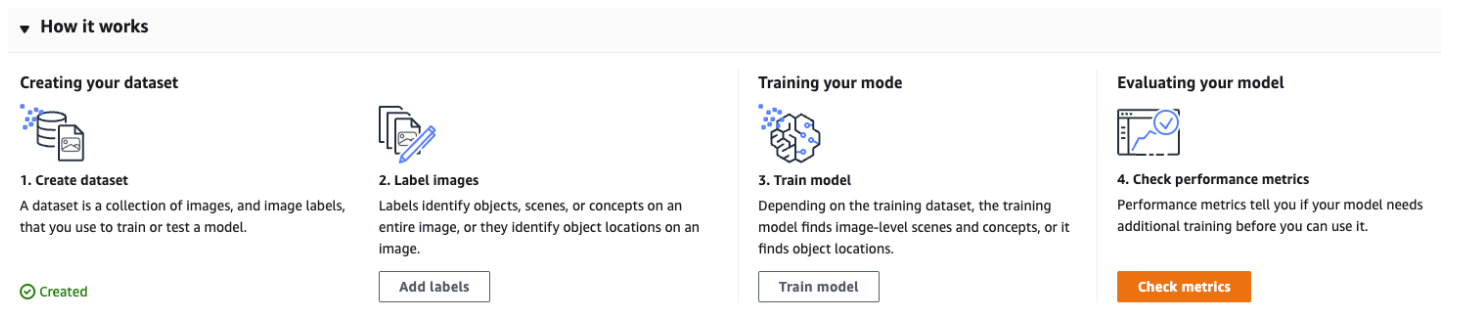

## Copying the dataset to S3 bucket

First, please make sure that the kernel is set to conda_python3

- Once you are loggged in to the console, create a S3 bucket with a unique name 

- Copy the images to the S3 bucket by running the below cell. 

In [ ]:
# change the bucket name in destination bucket

! aws s3 cp s3://ml-materials/images-rekognition-workshop/ s3://<paste your bucket name here>/images-subset/ --recursive

## Rekognition Custom Label Dataset Creation

Choose custom label and click "Get started" 
   - if you are using rekognition custom label for the first time, it will prompt you to create a S3 bucket. Please create it. The bucket will be automatically created by custom label and all the labelling and modelling artifacts will be stored here.
    
   - Click "Projects" > "Create project". Give project name and create project. Once the project is created you should see the below screen
   
   - Click on "Create dataset" and select "Start with a single dataset" 
   
   - Select "Import images from S3 bucket" 
   
   - Copy the S3 URI of the folder where the images were imported and paste it in the S3 URI location in console.
   
   - Create the dataset
   
   - Now you should see the images in your console

## Rekognition Custom Label Model Training

1. Now click on "Train model". Model training will take 1~2 hours. In the console, if you select your project, you should see a status like TRAINING_IN_PROGRESS. 

## Rekognition Custom Label Model Metric Verification

Once the model is trained, you should be able to see the results similar to the below.

You can click on `View test results` to look at individual test image result

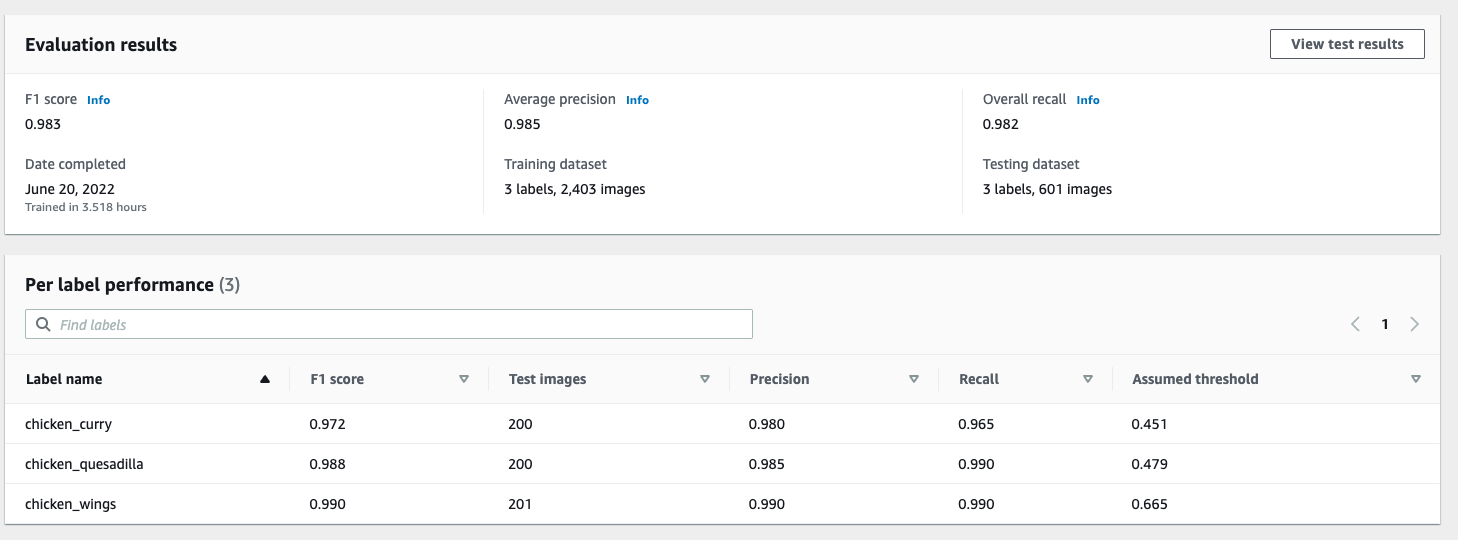

## Testing the model for inference

Now you can open JupyterLab and import the notebook.

In [9]:
# Import libraries and necessary set-up

import boto3
import io
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont
import json
import math

client=boto3.client('rekognition')
s3 = boto3.client('s3')
s3_connection = boto3.resource('s3')

my_bucket='rekognition-projects-2022'

## Start The Model

You can start the model from the console. You can select "use model" tab and click on "Start model".

You can also start the model using the below code. It might take up to 30 min to start the model.

In [2]:
%%time

import boto3

def start_model(project_arn, model_arn, version_name, min_inference_units):

    client=boto3.client('rekognition')

    try:
        # Start the model
        print('Starting model: ' + model_arn)
        response=client.start_project_version(ProjectVersionArn=model_arn, MinInferenceUnits=min_inference_units)
        # Wait for the model to be in the running state
        project_version_running_waiter = client.get_waiter('project_version_running')
        project_version_running_waiter.wait(ProjectArn=project_arn, VersionNames=[version_name])

        #Get the running status
        describe_response=client.describe_project_versions(ProjectArn=project_arn,
            VersionNames=[version_name])
        for model in describe_response['ProjectVersionDescriptions']:
            print("Status: " + model['Status'])
            print("Message: " + model['StatusMessage']) 
    except Exception as e:
        print(e)
        
    print('Done...')
    
def main():
    project_arn='arn:aws:rekognition:us-east-1:462768798410:project/Medi-AI/1655718158195'
    model_arn='arn:aws:rekognition:us-east-1:462768798410:project/Medi-AI/version/Medi-AI.2022-06-20T17.48.06/1655718486468'
    min_inference_units=1 
    version_name='Medi-AI.2022-06-20T17.48.06'
    start_model(project_arn, model_arn, version_name, min_inference_units)

if __name__ == "__main__":
    main()

Starting model: arn:aws:rekognition:us-east-1:462768798410:project/water-level/version/water-level.2022-02-03T15.23.44/1643873024451
Status: RUNNING
Message: The model is running.
Done...


## Import Test Images from S3

In [10]:
img = "mediai/images-subset/chicken_curry/1565684.jpg"

display(IImage(url=s3.generate_presigned_url('get_object', Params={'Bucket': my_bucket, 'Key': img}), width=800))

## Analyze Image

In [11]:
import boto3
import io
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont

def display_image(bucket,photo,response):
    # Load image from S3 bucket
    s3_connection = boto3.resource('s3')

    s3_object = s3_connection.Object(bucket,photo)
    s3_response = s3_object.get()

    stream = io.BytesIO(s3_response['Body'].read())
    image=Image.open(stream)

    # Ready image to draw bounding boxes on it.
    imgWidth, imgHeight = image.size
    draw = ImageDraw.Draw(image)

    # calculate and display bounding boxes for each detected custom label
    print('Detected custom labels for ' + photo)
    for customLabel in response['CustomLabels']:
        print('Label ' + str(customLabel['Name']))
        print('Confidence ' + str(customLabel['Confidence']))
        if 'Geometry' in customLabel:
            box = customLabel['Geometry']['BoundingBox']
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']

            fnt = ImageFont.truetype('/Library/Fonts/Arial.ttf', 50)
            draw.text((left,top), customLabel['Name'], fill='#00d400', font=fnt)

            print('Left: ' + '{0:.0f}'.format(left))
            print('Top: ' + '{0:.0f}'.format(top))
            print('Label Width: ' + "{0:.0f}".format(width))
            print('Label Height: ' + "{0:.0f}".format(height))

            points = (
                (left,top),
                (left + width, top),
                (left + width, top + height),
                (left , top + height),
                (left, top))
            draw.line(points, fill='#00d400', width=5)

    image.show()

def show_custom_labels(model,bucket,photo, min_confidence):
    client=boto3.client('rekognition')

    #Call DetectCustomLabels
    response = client.detect_custom_labels(Image={'S3Object': {'Bucket': bucket, 'Name': photo}},
        MinConfidence=min_confidence,
        ProjectVersionArn=model)

    # For object detection use case, uncomment below code to display image.
    # display_image(bucket,photo,response)

    return len(response['CustomLabels'])

def main():

    bucket = my_bucket
    photo = img
    model = 'arn:aws:rekognition:us-east-1:462768798410:project/Medi-AI/version/Medi-AI.2022-06-20T17.48.06/1655718486468'
    min_confidence=80

    label_count=show_custom_labels(model,bucket,photo, min_confidence)
    print("Custom labels detected: " + str(label_count))


if __name__ == "__main__":
    main()

Custom labels detected: 1


In [13]:
model = 'arn:aws:rekognition:us-east-1:462768798410:project/Medi-AI/version/Medi-AI.2022-06-20T17.48.06/1655718486468'

response = client.detect_custom_labels(Image={'S3Object': {'Bucket': bucket, 'Name': img}},
        MinConfidence=50,
        ProjectVersionArn=model)
print (json.dumps(response['CustomLabels'], indent=2))

[
  {
    "Name": "chicken_curry",
    "Confidence": 99.947998046875
  }
]


If you use bounding box labelling before training the model, you will also see bounding box co-ordinates here